<a href="https://colab.research.google.com/github/Lidiya-cutie/WineEnthusiastAnalysis/blob/master/WineEnthusiast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bинные обзоры

+ country - страна-производитель вина
+ description - подробное описание
+ designation - название виноградника, где выращивают виноград для вина
+ points - количество баллов, которое WineEnthusiast оценил вино по шкале от 1 до 100
+ price - стоимость бутылки вина
+ province - провинция или штат 
+ region_1 - винодельческий район в провинции или штате (например, Напа)
+ region_2 - конкретный регион. Иногда в пределах винодельческой зоны указываются более конкретные регионы (например, Резерфорд в долине Напа), но это значение иногда может быть пустым.
+ taster_name - имя дегустатора
+ taster_twitter_handle - твиттер дегустатора
+ title - название вина, который часто содержит годи др подробную информацию
+ variety -  сорт винограда, из которого изготовлено вино (например, Пино Нуар).
+ winery - винодельня, которая производила вино

## Знакомство с данными 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Импортируем необходимую библиотеку:
import pandas as pd
# Прочитаем наш файл с винными обзорами:
data = pd.read_csv('/content/wine.csv')

FileNotFoundError: ignored

Составим чек-лист всех этапов жизненного цикла модели машинного обучения для создания ИИ-сомелье. Подробно раскроем процесс разведывательного анализа данных с подэтапами.

* Определение бизнес-проблемы
* Сбор данных
* Очистка данных от пропусков/выбросов/аномалий
* Разведывательный анализ данных
    + проектирование признаков (генерация из внешних источников данных, из признаков датасета)
    + кодирование признаков
    + проверка статистических гипотез
    + отбор признаков
* Разработка модели
* Вывод модели в продакшн

Для начала узнаем, сколько всего дегустаторов приняло участие в винных обзорах. Чтобы правильно подсчитать количество дегустаторов, воспользуйтесь функцией *nunique()* применительно к столбцу *'taster_name'*..

In [ ]:
data['taster_name'].nunique()
# 19

19

Узнаем, какова максимальная цена за бутылку в этом наборе данных. Для этого воспользуемся функцией *max()* применительно к столбцу *'price'*.

In [ ]:
data['price'].max()
# 3300

3300.0

Проанализируем представленный датасет и перечислим все числовые признаки через запятую.

In [ ]:
data.describe()
# points, price

array([[<Axes: title={'center': 'points'}>,
        <Axes: title={'center': 'price'}>]], dtype=object)

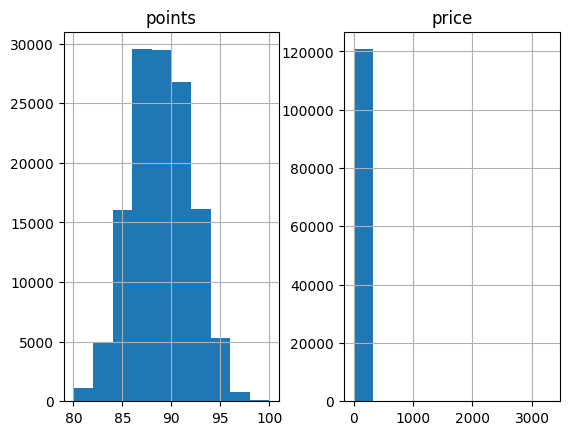

In [ ]:
# построим распеределение всех возможных признаков быстрой просто визуализацией
hist = data.hist()
hist

Проанализируем датасет на наличие дублирующихся винных обзоров. Если дублирующиеся записи есть, удалим их.
Посмотримб сколько дублирующихся записей удалось обнаружить. Для этого воспользуемся duplicated().count() и data.drop_duplicates().count().max() и вычислим разницу.

In [ ]:
drop_count = data.duplicated().count() - data.drop_duplicates().count().max()
print(f'Число найденных дубликатов: {drop_count}')
# Число найденных дубликатов: 9983

Число найденных дубликатов: 9983


или другим способом

In [ ]:
mask = data.duplicated(subset=data.columns) # маска для фильтрации
data_duplicates = data[mask] # фильтруем наш датасет
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 9983


Проверяем датасет на наличие пропусков в данных. Узнаем, в каких из представленных признаках были обнаружены пропуски

In [ ]:
data.info()
# designation, price, region_2, taster_twitter_handle - были обнаружены пропуски

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


Обработаем пропущенные значения в наборе данных. Импортируем библиотеки, которые нам понадобятся (pandas для работы с данными, numpy для математических преобразований, matplotlib и seaborn для визуализации).
* Если какой-то из признаков имеет более 30-40 % пропусков, лучше избавиться от него: его заполнение может привести к сильному искажению общего распределения, а удаление записей — к большой утрате данных.
* Заполним данные с умом! Если в данных количественный признак, то использование нецелого числа в качестве константы является как минимум нелогичным.
* Можно оставить пропуски как есть, просто заменив их на какой-то специальный символ. Например, для числовых неотрицательных признаков можно использовать число -1, а для категориальных — строку 'unknown'.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

В библиотеке *pandas* специально для этого реализован метод *isnull()*. Этот метод возвращает новый *DataFrame*, в ячейках которого стоят булевы значения *True* и *False*. *True* ставится на месте, где ранее находилось значение *NaN*.

Посмотрим на результат работы метода на нашей таблице:

In [ ]:
data.isnull()
# ячейки со значением True
# ячейки, где стоит False, были изначально заполнены.

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,False,False,False,False,True,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,True,True,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,False,False,False,False,False,False,True,True,False,True,False,False,False
129967,False,False,True,False,False,False,False,False,False,False,False,False,False
129968,False,False,False,False,False,False,False,True,False,False,False,False,False
129969,False,False,True,False,False,False,False,True,False,False,False,False,False


Выводим на экран названия столбцов, где число пропусков больше 0. 

Для этого вычислим средний по столбцам результат метода *isnull()*. Получим долю пропусков в каждом столбце.

*True* — 1, *False* — 0, при расчёте среднего получим долю 1 от общего числа строк. 
Умножаем на 100 %, находим **столбцы**, где доля пропусков больше 0, сортируем по убыванию и выводим результат:

Посмотрим на число записей:

In [ ]:
data.shape

(129971, 13)

In [ ]:
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent > 0.0000].sort_values(ascending=False)
cols_null_percent

country                   0.048472
description               0.000000
designation              28.825661
points                    0.000000
price                     6.921544
province                  0.048472
region_1                 16.347493
region_2                 61.136715
taster_name              20.192197
taster_twitter_handle    24.015357
title                     0.000000
variety                   0.000769
winery                    0.000000
dtype: float64

Итак, можно увидеть, что у нас большое число пропусков (более 61 %) в столбце *region_2* (конкретный регион в пределах винодельческой зоны). 

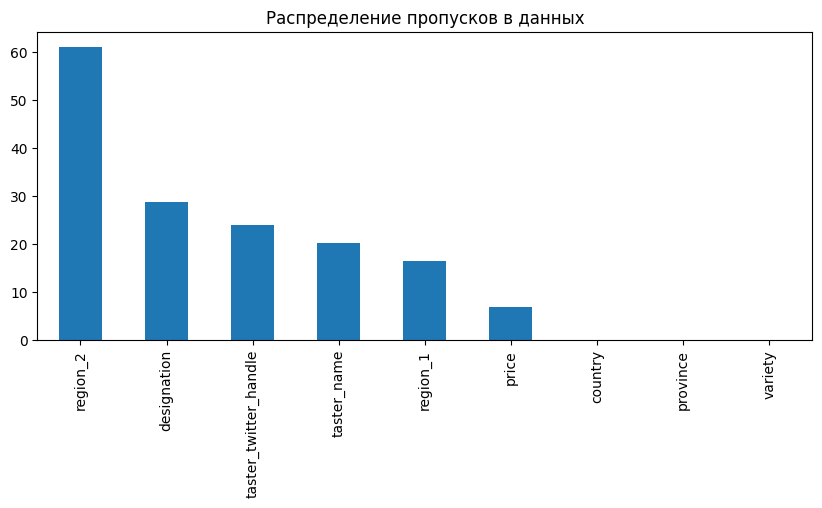

In [ ]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

* Удаляем столбцы с числом пропусков более 30 %.
* Удаляем записи, в которых более двух пропусков одновременно.
* Заполним пропуски.

In [ ]:
# оздаём копию исходной таблицы
drop_data = data.copy()
# число строк в таблице
count = drop_data.shape[0]
# отбрасываем столбцы с числом пропусков более 30% (100-70)
min_drop = count * 0.7
drop_data = drop_data.dropna(thresh=min_drop, axis=1)
# число строк в таблице, где пропусков более 2-х в строке
drop_two = drop_data.shape[1]
# число признаков после удаления столбцов
drop_data = drop_data.dropna(thresh=drop_two-2, axis=0)
# создаём словарь 'имя_столбца': число (признак), на который надо заменить пропуски 
values = {
    'country': drop_data['country'].fillna('US'),
    'variety': drop_data['variety'].fillna('Pinot Noir'),
    'regiion_2': 'unknown',
    'designation': 'unknown',
    'taster_twitter_handle': 'unknown',
    'province': drop_data['province'].fillna('California'),
    'region_1': 'unknown',
    'taster_name': 'unknown',
    'price': round(drop_data['price'].mean())
}
# заполняем пропуски в соответствии с заявленным словарем
drop_data = drop_data.fillna(values)
drop_data.isnull().mean()

country                  0.0
description              0.0
designation              0.0
points                   0.0
price                    0.0
province                 0.0
region_1                 0.0
taster_name              0.0
taster_twitter_handle    0.0
title                    0.0
variety                  0.0
winery                   0.0
dtype: float64

In [ ]:
# Посмотрим на результирующее число записей:
drop_data.shape

(119230, 12)

<Axes: >

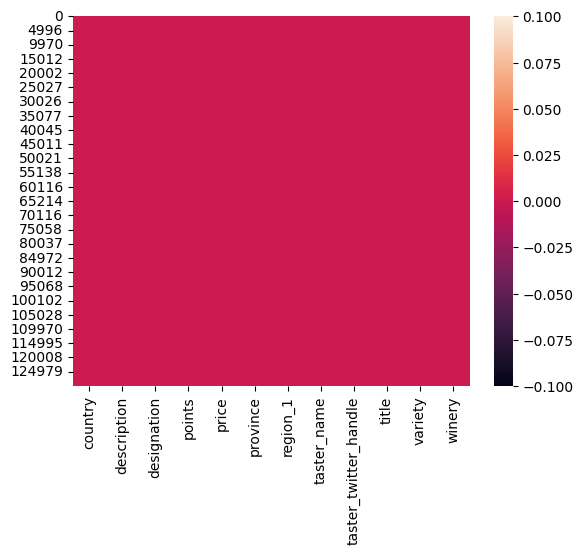

In [ ]:
# Убеждаемся, что датасет без пропусков
sns.heatmap(drop_data.isnull()) 

In [ ]:
# сохраняем очищенный датасет для дальнейшей работы
df = drop_data.to_csv('wine_cleared.csv', index=False) 

## РАБОТАС ОЧИЩЕННЫМИ ДАННЫМИ ВИННЫХ ОБЗОРОВ

In [ ]:
# Импортируем необходимую библиотеку:
import pandas as pd
# Прочитаем наш файл с винными обзорами:
data = pd.read_csv('/content/wine_cleared.zip')

Вычислим наименьший балл за вино в датасете. Для этого воспользуемся функцией *min()* применительно к столбцу *points*

In [ ]:
data['points'].min()

80

Вычислим теперь наименьшую цену за бутылку в наборе данных.

In [ ]:
data['price'].min()

4.0

### СРЕДНЕЕ АРИФМЕТИЧЕСКОЕ

Далее мы рассмотрим наиболее популярные меры центральной тенденции, используемые в машинном обучении: среднее арифметическое, медиана, мода. Для расчёта этих описательных статистик в *Python* мы будем пользоваться библиотекой [statistics](https://docs.python.org/3/library/statistics.html). Она предоставляет готовые функции для вычисления математической статистики для числовых данных.

In [ ]:
# Установим библиотеку:
!pip install statistics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7453 sha256=141c7cbdf093a84a2afe97bf2005124faa25952e18b001c8b2261f5ee113b1af
  Stored in directory: /root/.cache/pip/wheels/26/3c/70/9467407f3aa90862061eadcd286627b23a8bab6789b667776f
Successfully built statistics


In [ ]:
# Импортируем библиотеку для дальнейшего использования:
import statistics

Вычислите среднюю стоимость бутылки вина при помощи функции *statistics.mean()* библиотеки [statistics](https://docs.python.org/3/library/statistics.html#statistics.mean). Округлите значение до сотых.

In [ ]:
round(statistics.mean(data['price']),2)

35.36

Вычислите среднюю стоимость бутылки вина при помощи стандартных функций Python.

In [ ]:
mean = sum(data['price']) / len(data['price'])
# or data['price'].mean()

35.363389129985535

**Среднее арифметическое** хорошо работает для признаков с небольшим разбросом в значениях, например чтобы корректно вычислять средний возраст популяции. Однако оно плохо работает для признака с большим разбросом в значениях. 

### МЕДИАНА

**Медиана** — средний элемент распределения. Для расчёта медианы должно выполняться одно условие: числовой ряд должен быть предварительно отсортирован. Только так мы сможем корректно рассчитать средний элемент. Признак может быть отсортирован как по возрастанию, так и по убыванию. 

Методы современных библиотек, в том числе и используемой нами statistics для вычисления медианы, самостоятельно выполняют сортировку данных — вам не нужно заботиться об этом. 

Медиана делит распределение признака ровно пополам

Если количество элементов чётное, медианой будет среднее арифметическое двух средних элементов распределения.

Вычислите медиану стоимости бутылки вина при помощи функции [statistics.median()](https://docs.python.org/3/library/statistics.html#statistics.median) библиотеки *statistics*. Округлите значение до сотых.

In [12]:
statistics.median(data['price'])

28.0

Вычислите медиану стоимости бутылки вина при помощи стандартных функций Python.

Вставьте получившийся код:

In [ ]:
count_price = len(data['price']) # количество записей цен
sorted_price = sorted(data['price']) # отсортированные цены

if count_price % 2: # при нечетном кол-ве элементов выбираем средний по индексу 
    median = sorted_price[round(0.5*(count_price-1))]
else: # при четном кол-ве элементов выбираем 2 средних по индексу и считаем между ними среднее арифметическое
    index = round(0.5 * count_price)
    median_ = 0.5 * (sorted_price[index-1] + sorted_price[index])
median

В отличие от среднего арифметического медиана хорошо справляется с разбросом в значениях, поэтому её чаще используют. Также медиана разбивает данные на две группы, состоящие из одинакового количества элементов.

Средние значения, например уровень дохода или цена на недвижимость, часто вычисляются именно по медиане, потому что в этом случае важен средний уровень доходов большей части населения. В таком случае основатель Amazon Джефф Безосс с годовым доходом в несколько миллиардов не испортит нам всю статистику. 

Также в библиотеке *statistics* есть функции, связанные с медианой, — функция [statistics.median_low()](https://docs.python.org/3/library/statistics.html#statistics.median_low) и функция [statistics.median_high()](https://docs.python.org/3/library/statistics.html#statistics.median_high).

→ В случае, когда количество элементов в числовом ряду (серии) нечётное, функции возвращают то же, что и median().

В случае, когда количество элементов чётное, у нас получается два средних значения:

* median_low() возвращает меньшее из них;
* median_high() возвращает большее из них.

**Примечание**. Если в вашем наборе данных есть пропущенные значения, функции библиотеки *statistics* в отличие от других методов (например [np.median()](https://numpy.org/doc/stable/reference/generated/numpy.median.html) из библиотеки numpy) будут автоматически игнорировать пропущенные значения, не выдавая ошибку.



### МОДА

**Мода** — самый часто встречающийся элемент в числовом ряду.

Чаще всего мода используется **в нечисловых рядах**. Например самая популярная порода собак, фильм года, лучшие рестораны вычисляются именно модой.

Вычислите моду стоимости бутылки (самую часто встречающуюся цену) вина при помощи функции [statistics.mode()](https://docs.python.org/3/library/statistics.html#statistics.mode) библиотеки *statistics*. Округлите значение до сотых.

In [14]:
mode_price = round(statistics.mode(data['price']), 2)
print(f'Самая часто встречающаяся цена бутылки вина - {mode_price}')

Самая часто встречающаяся цена бутылки вина - 35.36


Моду также можно вычислить при помощи [statistics.multimode()](https://docs.python.org/3/library/statistics.html#statistics.multimode). В случае наличия нескольких модовых (популярных значений) функция *statistics.mode()* вернёт вам ошибку *StatisticsError*, а *statistics.multimode()* — список с всеми вычисленными модовыми значениями.

Вычислите моду стоимости бутылки (самую часто встречающуюся цену) вина при помощи стандартных функций *Python* и *pandas*.

Вставьте получившийся код:

In [17]:
mode = round(data["price"].value_counts().index[0], 2)
print(f'Самая часто встречающаяся цена бутылки вина - {mode}')
# Результат вывода аналогичен предыдущему, но код получился более лаконичным

Самая часто встречающаяся цена бутылки вина - 35.36


Мы рассмотрели самые основные и часто используемые в машинном обучении меры центральной тенденции. Также к мерам центральной тенденции относятся:

* среднее геометрическое;
* среднее гармоническое;
* средневзвешенное и другие.

Их также можно вычислить с помощью библиотеки *statistics*, но они реже используются для описания распределения в машинном обучении.

### КОРРЕЛЯЦИЯ

**Корреляция** — статистическая связь двух и более переменных. При изменении значения одной из переменных происходит закономерное изменение другой или других величин. 

**Корреляция** — статистическая связь двух и более переменных. При изменении значения одной из переменных происходит закономерное изменение другой или других величин. 

Например, при взрослении у человека меняются его показатели: рост становится больше, риск сердечно-сосудистых заболеваний — выше.

Мерой связи величин, мерой корреляции является **коэффициент корреляции**. Он может принимать значение от -1 до +1.

**Отрицательная корреляция**, коэффициент корреляции < 0 говорит об обратной связи между переменными. При обратной связи увеличение одной из величин ведёт к закономерному уменьшению другой (других) величин. 

Например, чем больше сумма активного долга, тем меньше шанс в одобрении кредита.

**Положительная корреляция**, коэффициент корреляции > 0 говорит о прямой связи между переменными. При прямой связи увеличение одной из величин ведёт к закономерному увеличению другой (других) величин. 

 Например, с увеличением возраста размер ноги человека увеличивается, и его рост увеличивается тоже.

**Коэффициент корреляции** = 0 говорит о том, что переменные независимы друг от друга, по крайней мере линейно, но это вовсе не значит, что между ними нет какой-то более сложной взаимосвязи. Это достаточно редкое явление, которое может встретиться на конкретном наборе данных.

Понимание корреляции приводит нас к понятию **мультиколлинеарности** — такой сильной зависимости переменных друг от друга, что она затрудняет анализ и оценку будущей модели машинного обучения. 

Для расчёта коэффициента корреляции применим функцию [df.corr()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) библиотеки pandas.

data.corr()

Вычислите коэффициент корреляции между переменными в датасете винных обзоров. В ответ запишите величину коэффициента корреляции между ценой за бутылку и баллами за вино. Округлите ответ до шести знаков после запятой.

In [21]:
data.corr()

<ipython-input-21-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,Unnamed: 0,points,price
Unnamed: 0,1.000000,0.007124,0.004652
points,0.007124,1.000000,0.402137
price,0.004652,0.402137,1.000000


Результатом функции *df.corr()* является матрица корреляции. 

**Матрица корреляции** — таблица, заголовками и строками которой являются названия признаков в датасете. На пересечении строк и столбцов находится значение коэффициента корреляции этих двух признаков.

Данная матрица имеет значение 1 по главной диагонали, так как единица означает корреляцию признака с самим собой. Матрица является **симметричной**. 

## РАБОТА С YDATA-PROFILING НА ПРИМЕРЕ ВИННЫХ ОБЗОРОВ

*Ydata-profiling* — это библиотека с открытым исходным кодом, которая создаёт подробный отчёт по данным. *Ydata-profiling* можно легко использовать для больших наборов данных: отчёты создаются всего за несколько секунд.

In [ ]:
# Для начала установка (выполните в терминале или ячейке ноутбука):
!pip install -U ydata-profiling
!pip install ipywidgets

In [ ]:
# Импортируем для работы
import pandas as pd
from ydata_profiling import ProfileReport
# Считываем наш датафрейм
wine = pd.read_csv('wine.csv')

In [ ]:
# Сгенерируем отчёт одной строкой.
profile = ProfileReport(wine, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Для того, чтобы сохранить собственный отчёт в виде HTML-файла, вы можно воспользоваться методом to_file(), передав в него путь до файла, в который вы хотим сохранить результат:

In [ ]:
profile.to_file("your_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Данный результат отчёта *ydata-profiling* можно использовать для первичной визуализации набора данных, числового и статистического анализа переменных, с которым вы познакомитесь в следующих моделях по статистике. Также отчёт используется для вывода корреляции переменных, выявления пропущенных значений, а также для просмотра первых и последних строк набора данных.

Подробнее с возможностями библиотеки вы можете познакомиться в [документации](https://ydata-profiling.ydata.ai/docs/master/pages/getting_started/overview.html)

## РАБОТА СО SWEETVIZ НА ПРИМЕРЕ ВИННЫХ ОБЗОРОВ

*Sweetviz* — это библиотека автоматического анализа с открытым исходным кодом. *Sweetviz* также можно использовать для сравнения нескольких наборов данных и выводов по ним. Это может быть удобно, когда необходимо сравнить обучающий и тестовый наборы данных. Об этом вы узнаете далее в модулях про машинное обучение.


In [ ]:
# Установка:
!pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Начнем свою работу с импорта необходимых библиотек 
import pandas as pd
import sweetviz as sv
# и загрузки датасета винных обзоров
df = pd.read_csv('wine.csv')

Чтобы проанализировать набор данных, просто используйте функцию *analyze()*, а затем — *show_html()*:

/usr/local/lib/python3.9/dist-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/usr/local/lib/python3.9/dist-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.9/dist-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/usr/local/lib/python3.9/dist-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/usr/local/lib/python3.9/dist-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/usr/local/lib/python3.9/dist-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/u


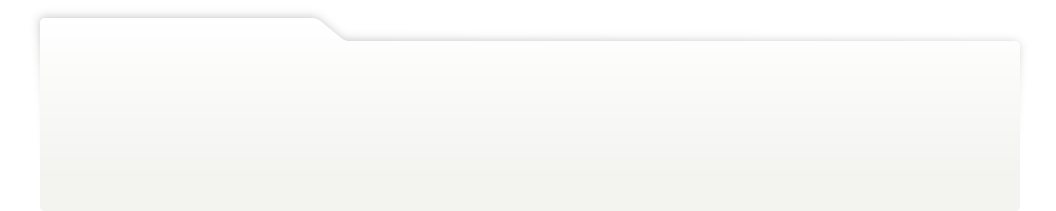
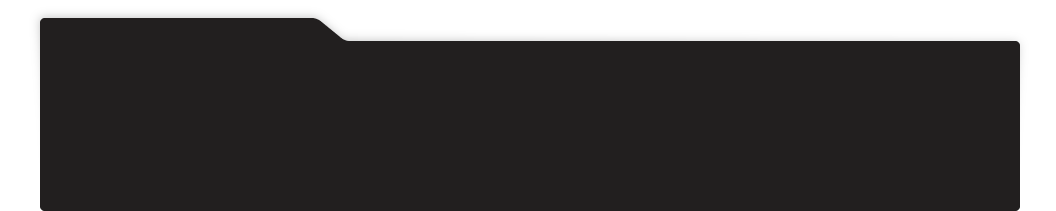
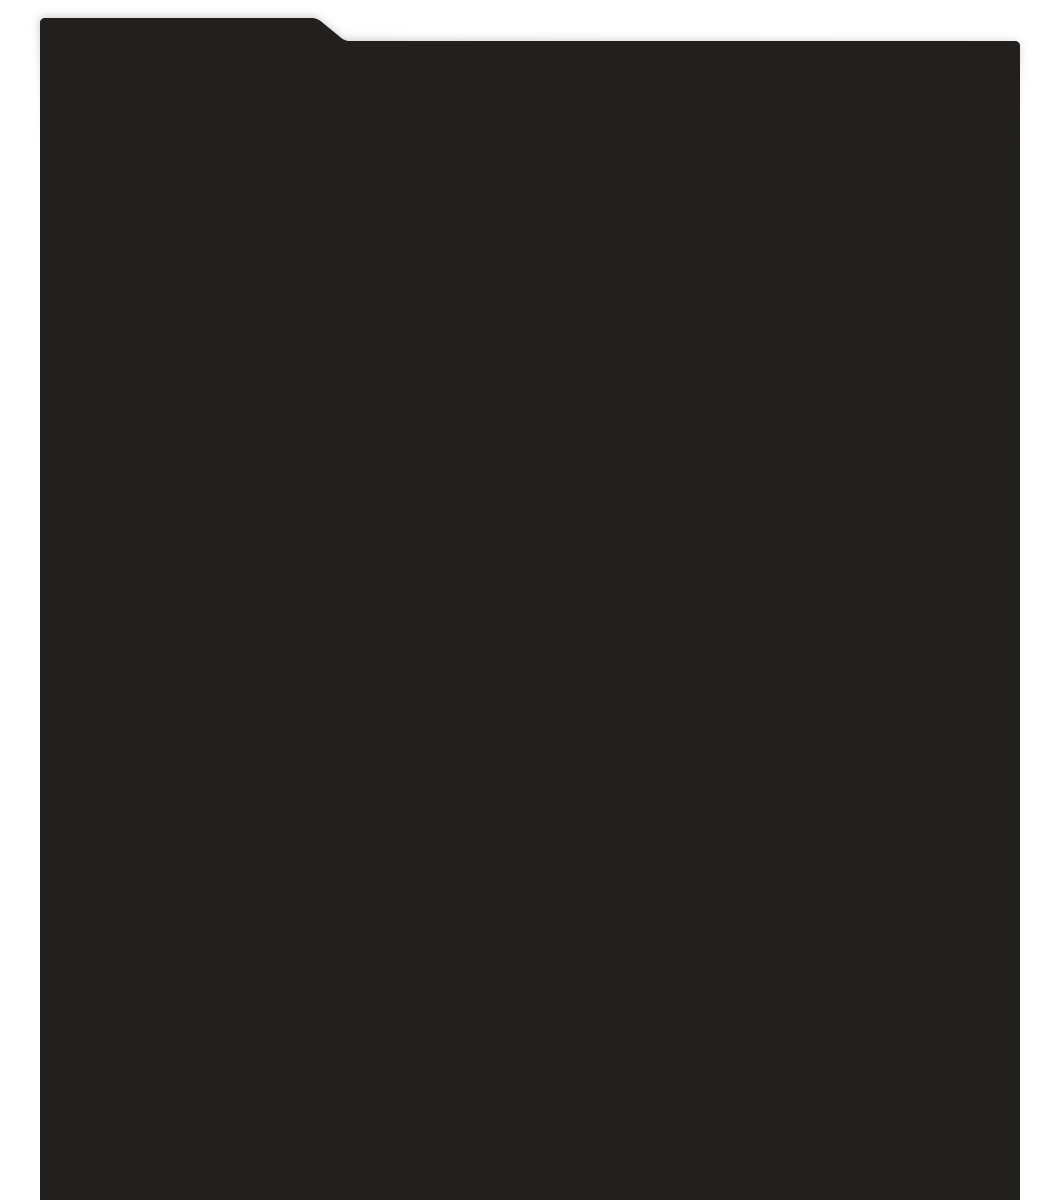
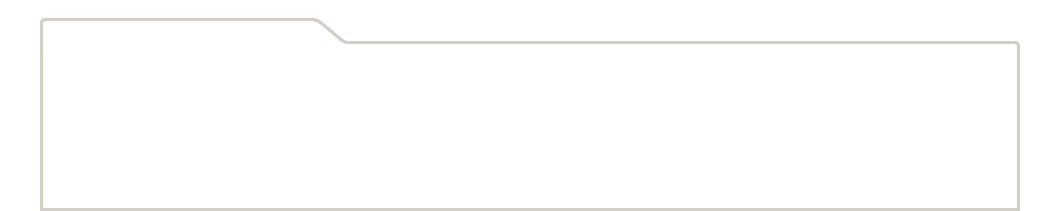
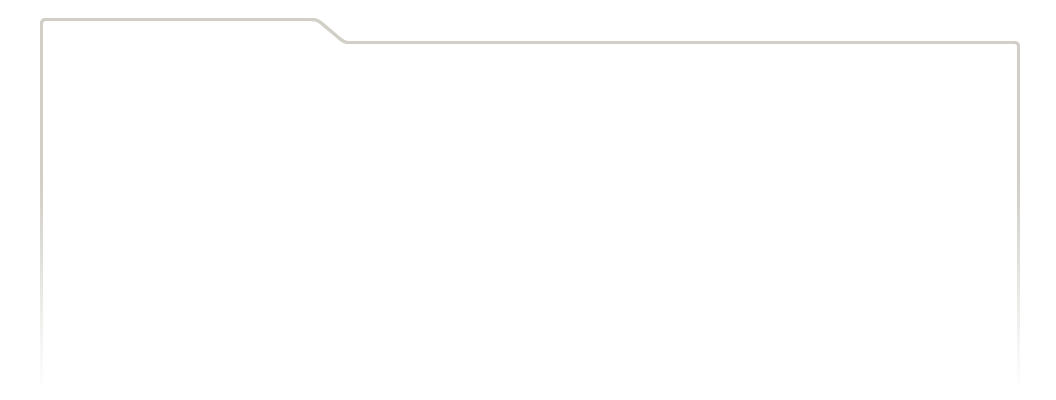
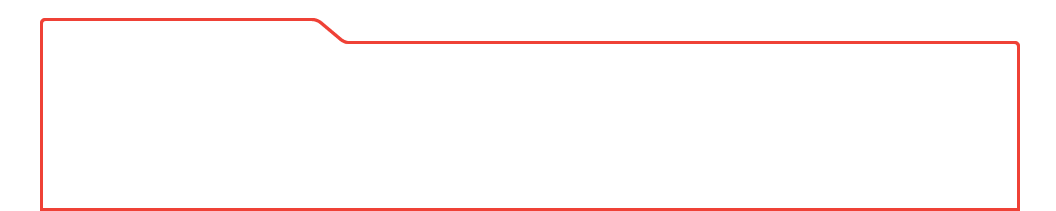
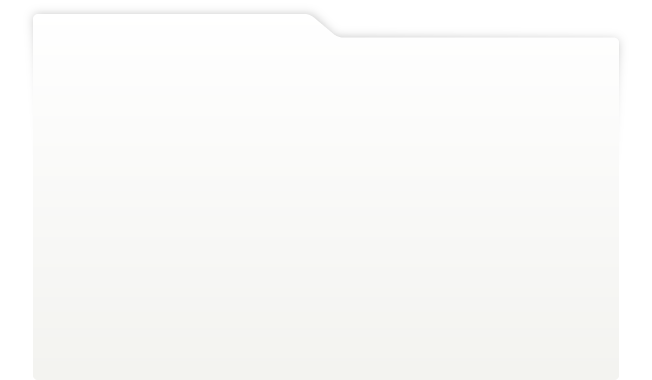
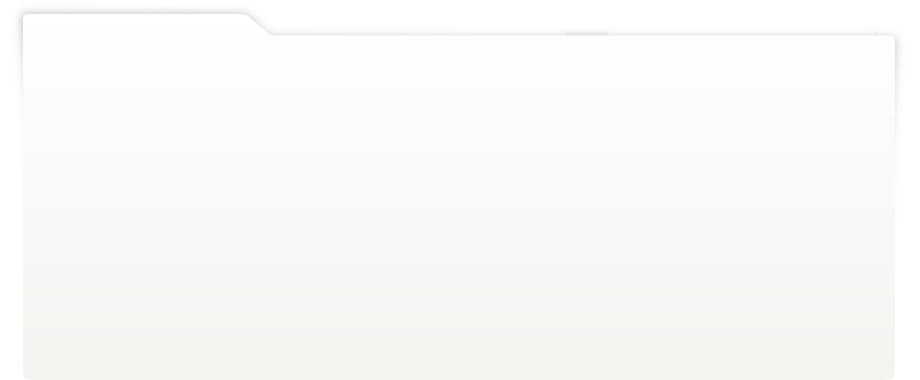
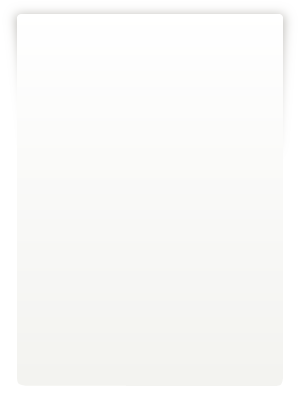
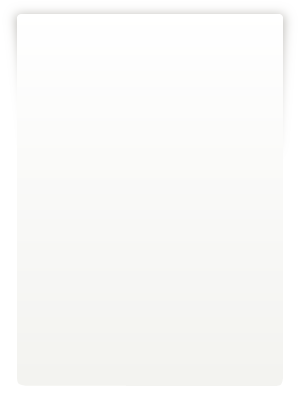
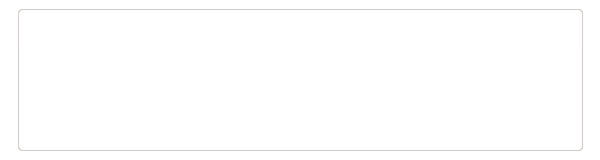
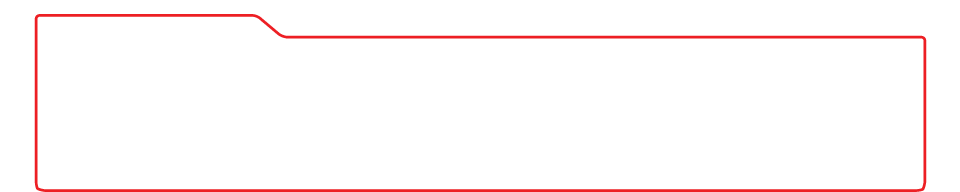
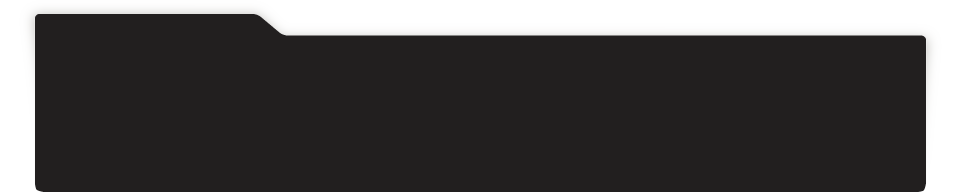
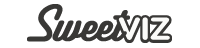
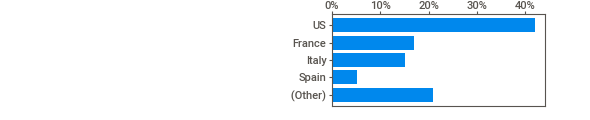
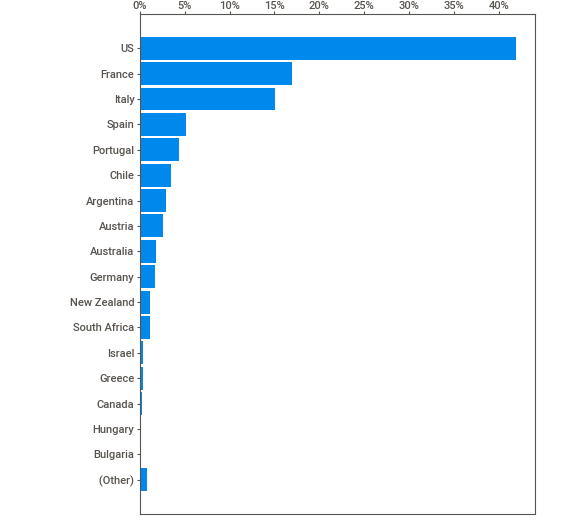
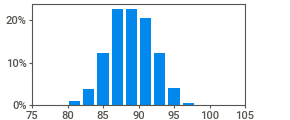
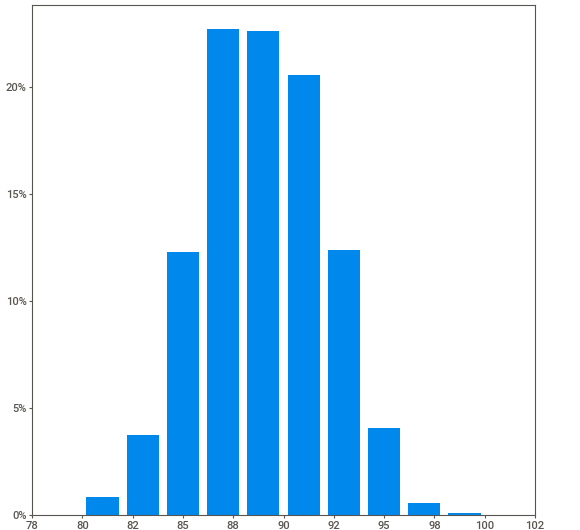
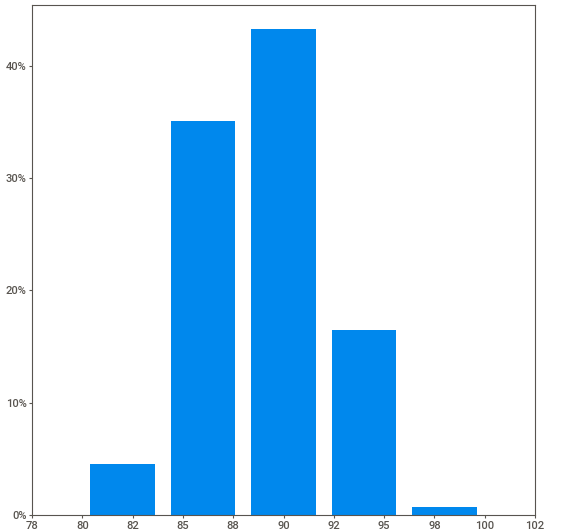
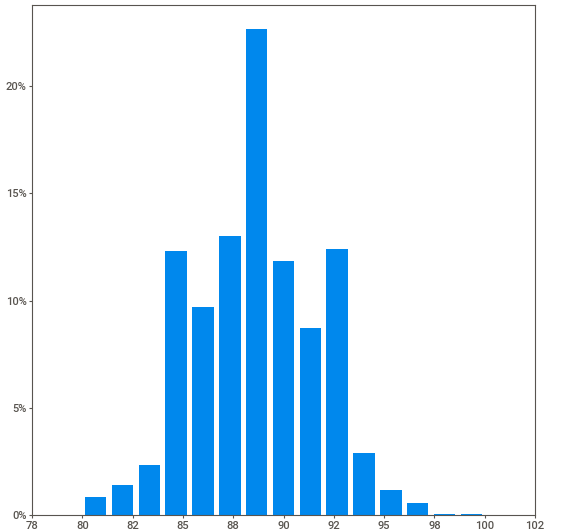
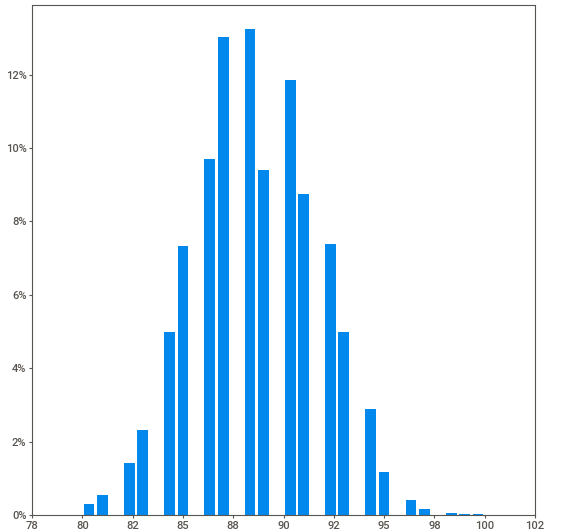
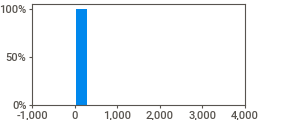
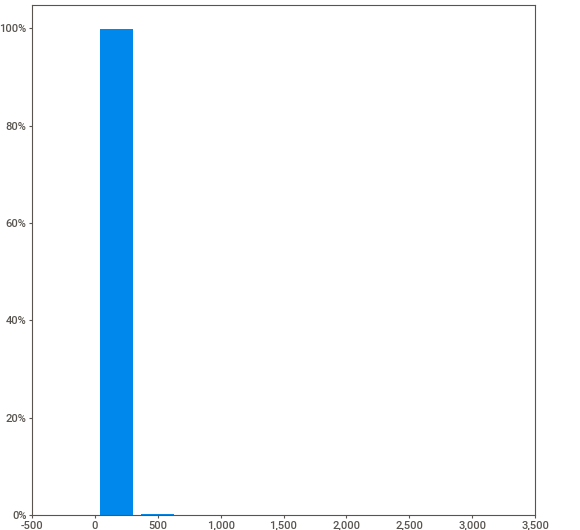
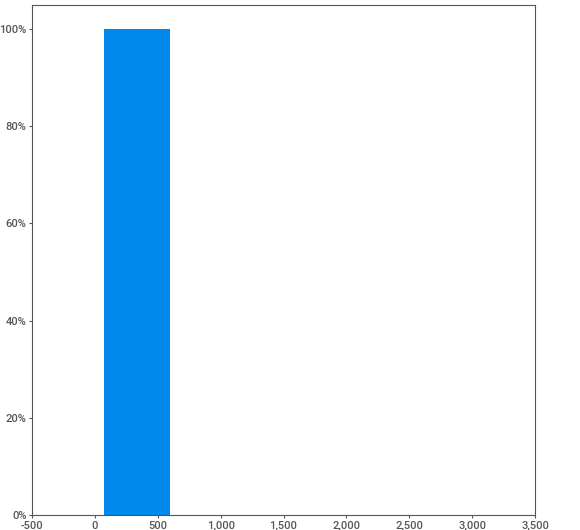
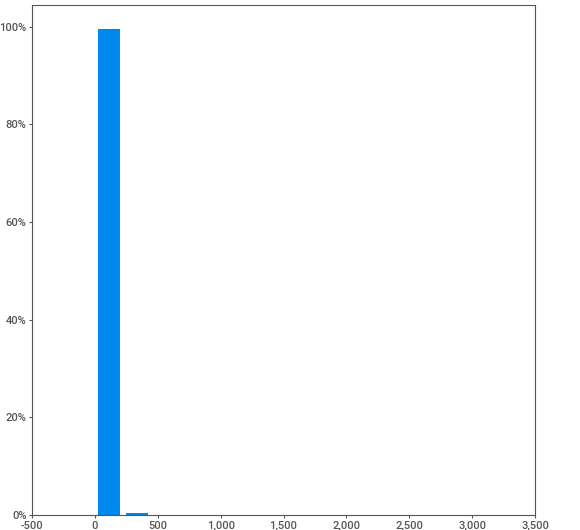
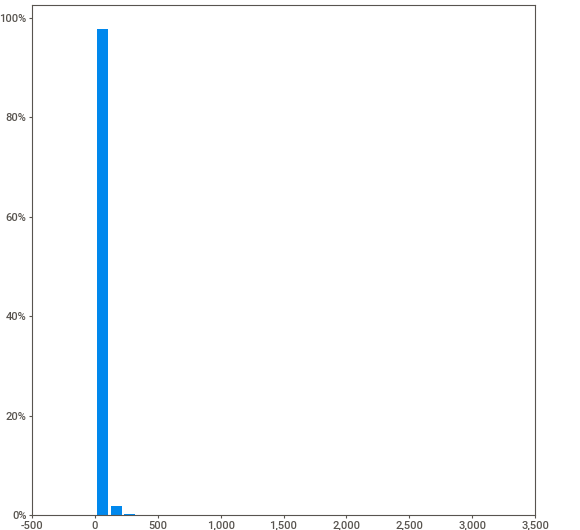
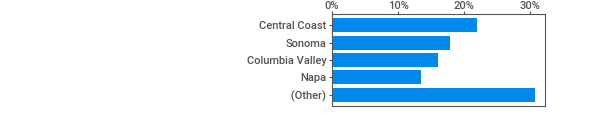
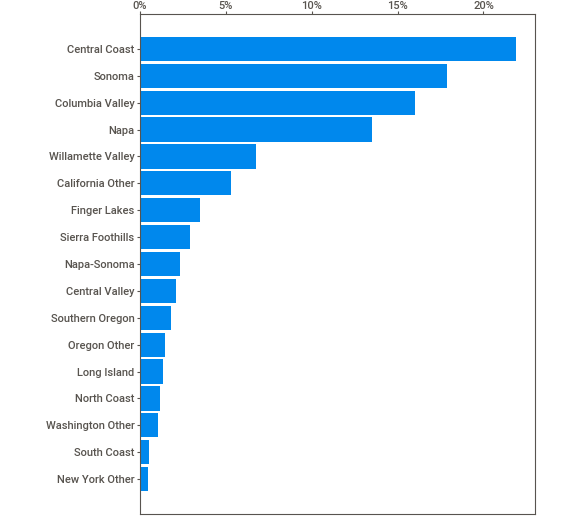
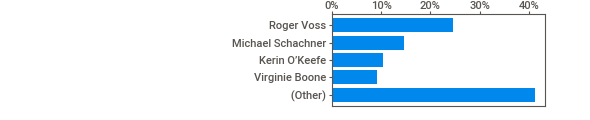
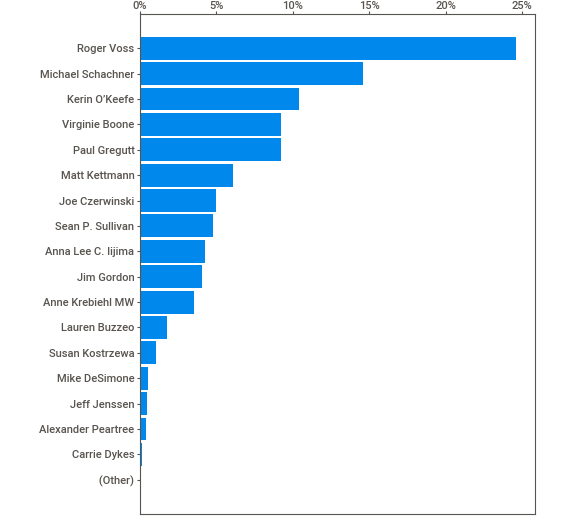
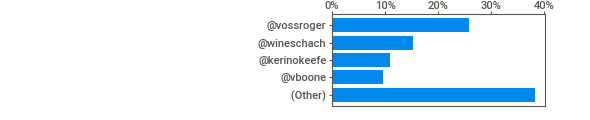
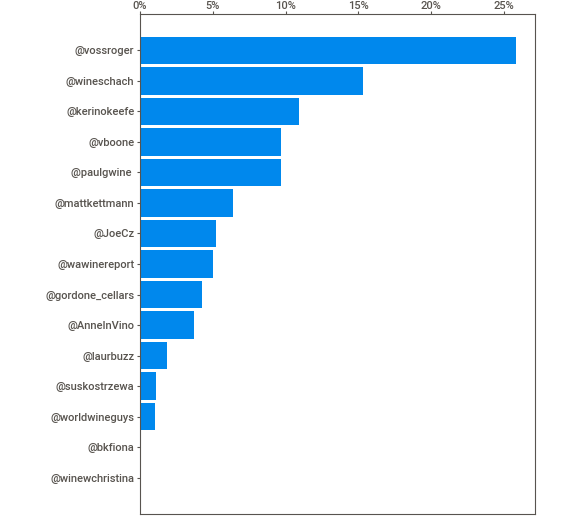
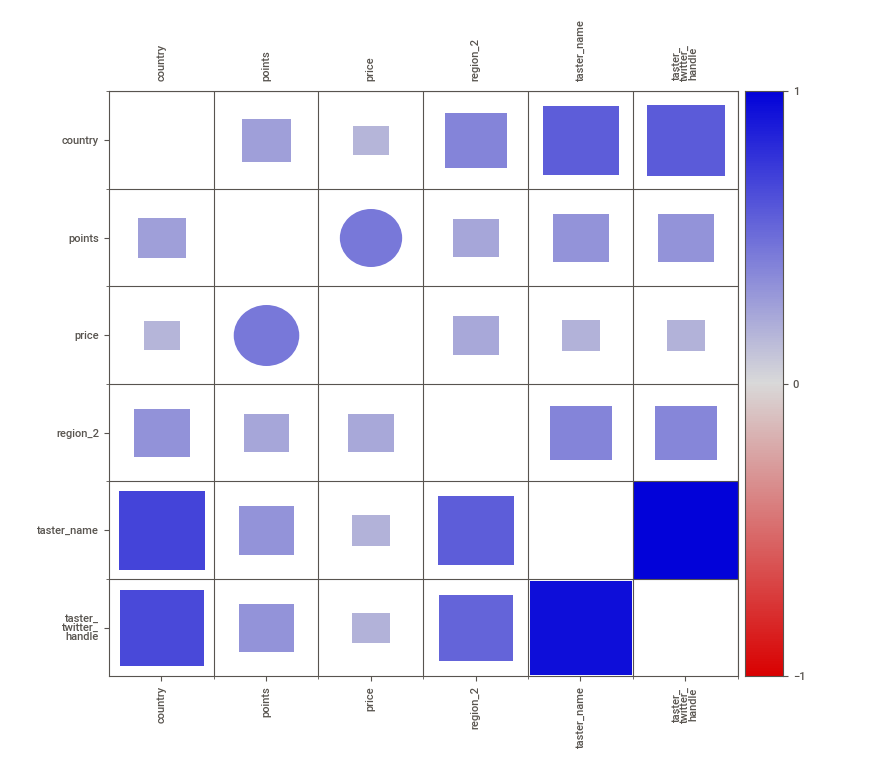
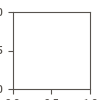

In [ ]:
report = sv.analyze(df)
report.show_notebook() # or use report.show_html

Подробнее с возможностями библиотеки вы можете познакомиться в [документации](https://github.com/fbdesignpro/sweetviz).

## РАБОТА С D-TALE НА ПРИМЕРЕ ВИННЫХ ОБЗОРОВ

*D-Tale* — это библиотека с открытым исходным кодом. *D-Tale* делает подробный разведывательный анализ набора данных. Интересная особенность: библиотека предоставляет функцию экспорта кода для каждого графика или элемента анализа в отчёте.

In [ ]:
# Установка:
!pip install dtale

In [ ]:
# Начнем свою работу с импорта необходимых библиотек 
import pandas as pd
import dtale
# и загрузки датасета винных обзоров
df = pd.read_csv('wine.csv')

In [ ]:
# Сгенерируйте отчёт одной строкой.
dtale.show(df)

/usr/local/lib/python3.9/dist-packages/dtale/views.py:756: FutureWarning:

['country', 'designation', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'variety'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.



http://a0a0b2e464c4:40000/dtale/main/3

Подробнее с возможностями библиотеки вы можете познакомиться в [документации](https://github.com/man-group/dtale).

## СРАВНЕНИЕ БИБЛИОТЕК

In [ ]:
|           Основные возможности             |             библиотека            |
|                                            |Ydata-profiling | Sweetviz | D-Tale|
| Тип, уникальные значения,                  |                |          |       |
| пропущенные значения, повторяющиеся строки,|       +        |     +    |   +   |
| наиболее частые значения                   |                |          |       |
|--------------------------------------------|-----------------------------------|
| Числовой анализ (мин, макс,                |        +       |     +    |   +   |
|       квартили, мода/медиана)              |                |          |       |
|--------------------------------------------|----------------|----------|-------|
| Описательная статистика                    |        +       |     +    |   +   |
|--------------------------------------------|----------------|----------|-------|
| Визуализация                               |        +       |     +    |   +   |
|--------------------------------------------|----------------|----------|-------|
| Сравнение различных наборов данных         |        -       |     +    |   +   |
|--------------------------------------------|----------------|----------|-------|
| Экспорт кода                               |        -       |     -    |   +   |